In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import mean_squared_error

from spicy_snow.retrieval import retrieval_from_parameters

In [38]:
npys_dir = Path('~/scratch/spicy/param_npys/Banner_2021-03-15/').expanduser()
lidar = np.load(npys_dir.joinpath('lidar.npy'))
trees = np.load(npys_dir.joinpath('trees.npy'))
elev = np.load(npys_dir.joinpath('elev.npy'))

In [23]:
params = {fp.stem.replace('.npy', ''):fp for fp in npys_dir.glob('*_*_*.npy')}

In [28]:
A = np.unique([k.split('_')[0] for k in params.keys()])
B = np.unique([k.split('_')[1] for k in params.keys()])
C = np.unique([k.split('_')[2] for k in params.keys()])

In [30]:
optimal_a = 1.1
optimal_b = 2.0
optimal_c = 0.39

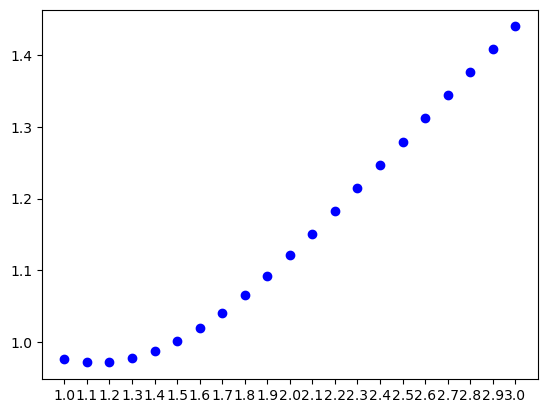

In [52]:
fig,ax = plt.subplots()
for a in A:
    spicy = np.load(params[f'{a}_{optimal_b}_{optimal_c}'])
    rms = mean_squared_error(lidar, spicy, squared=False)
    ax.scatter(a, rms, color = 'blue')
# for b in B:
#     spicy = np.load(params[f'{optimal_a}_{b}_{optimal_c}'])
#     rms = mean_squared_error(lidar, spicy, squared=False)
#     ax.scatter(b, rms, color = 'red')
# for c in C:
#     spicy = np.load(params[f'{optimal_a}_{optimal_b}_{c}'])
#     rms = mean_squared_error(lidar, spicy, squared=False)
#     ax.scatter(c, rms, color = 'green')
# ax.set_xlim(0, 3)

In [71]:
dataset = xr.load_dataset('/bsuhome/zacharykeskinen/scratch/spicy/SnowEx-Data-params/Banner_2021-03-15.nc')

In [72]:
def calc_snowdepth(dataset, a,b,c, closest_ts, lidar_ds):
    
    ds2 = retrieval_from_parameters(dataset, a,b,c)
    ds_closest_ts = ds2.sel(time=closest_ts, method = 'nearest')
    spicy_masked = ds_closest_ts.snow_depth.where(lidar_ds['lidar-sd']>=0)
    lidar_masked = lidar_ds['lidar-sd'].where(spicy_masked>=0)
    
    return spicy_masked, lidar_masked

In [84]:
factors = np.arange(0.9,1.1,0.05)
a,b,c = list(), list(), list()
a_rmse, b_rmse, c_rmse = list(), list(), list()
a_bias, b_bias, c_bias = list(), list(), list()

closest_ts = '2021-03-15'
ds_optimal, lidar_optimal = calc_snowdepth(dataset, optimal_a, optimal_b, optimal_c, closest_ts, dataset)

for f in factors:
    print(f'factor:{f}')
    print(f'new params:{optimal_a+optimal_a*f}, {optimal_b+optimal_b*f}, {optimal_c+optimal_c*f}')
    ds_a, lidar_masked = calc_snowdepth(dataset, optimal_a+optimal_a*f, optimal_b, optimal_c, closest_ts,dataset)
    a.append((ds_optimal.mean()-ds_a.mean())/ds_optimal.mean())
    a_rmse.append(np.sqrt(((ds_a - lidar_masked)**2).mean()))
    a_bias.append((ds_a - lidar_masked).mean())
    
    ds_b = calc_snowdepth(dataset, optimal_a, optimal_b+optimal_b*f, optimal_c, closest_ts,dataset)
    b.append((ds_optimal.mean()-ds_b.mean())/ds_optimal.mean())
    b_rmse.append(np.sqrt(((ds_b - lidar_masked)**2).mean()))
    b_bias.append((ds_b - lidar_masked).mean())
    
    ds_c = calc_snowdepth(dataset, optimal_a, optimal_b, optimal_c+optimal_c*f, closest_ts,dataset)
    c.append((ds_optimal.mean()-ds_c.mean())/ds_optimal.mean())
    c_rmse.append(np.sqrt(((ds_c - lidar_masked)**2).mean()))
    c_bias.append((ds_c - lidar_masked).mean())

factor:0.9
new params:2.0900000000000003, 3.8, 0.7410000000000001


AttributeError: 'tuple' object has no attribute 'mean'

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

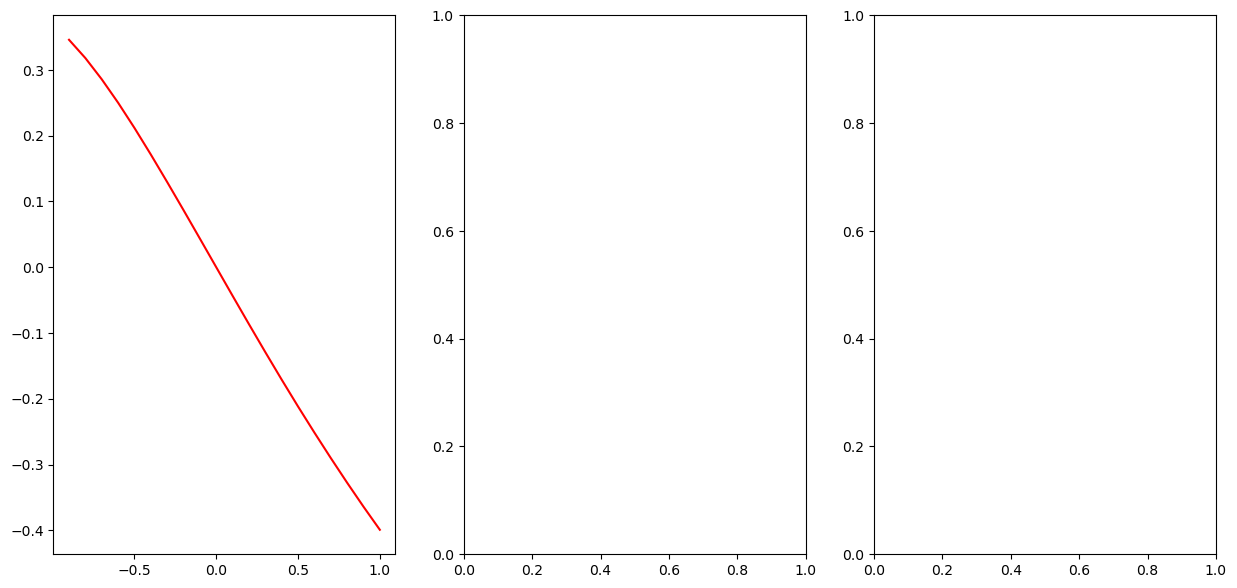

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (15,7))

ax[0].plot(factors, a,'r-', label = "A parameter")
ax[0].plot(factors, b,'b-', label = "B parameter")
ax[0].plot(factors, c,'g-', label = "C parameter")
ax[0].set_xlabel('% change in parameter from optimal value')
ax[0].set_ylabel('% change in mean snowdepth')
ax[0].set_title('Opptimal values:\n A = 1.1, B = 2.0, C = 0.39')